# Identify Fraud From Enron Data
###  Bhushan Pagare
___

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. Here, I build a supervised learning algorithm to identify fraudulent employees using Enron dataset.

## Introduction

The Enron fraud is the largest case of corporate fraud in American history. Founded in 1985, Enron Corporation went bankrupt by end of 2001 due to widespread corporate fraud and corruption. Before its fall, Fortune magazine had named Enron "America's most innovative company" for six consecutive years. So what happened? Who were the culprits?

In this project, I will play detective and build a classification algorithm to predict a person of interest identifier (POI) based on email and financial features in the combined dataset. A POI is anyone who has been indicted, settled without admitting the guilt and testified in exchange for immunity. We will check our predicted POI against actual POI 
in the dataset to evaluate our prediction.


In [1]:
### Importing Common Modules needed for project
from time import time   # For calculating training time
import pandas as pd    # Pandas is used for handling dataFrames
import pickle      # Pickle is used to load .pkl dataset files
import matplotlib.pyplot as plt    # Pyplot is used for visualizing the information
from sklearn.feature_selection import SelectKBest, f_classif    # For Selecting K-Best features of availabel ones
from sklearn.model_selection import train_test_split, GridSearchCV   # train_test_split for splitting up data
                                                                     # into train and test
                                                                     # GridSearchCV for finding best parameters tuned
from sklearn.model_selection import StratifiedShuffleSplit   # For Cross-Validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # For evaluating different algorithms
import numpy as np     # Numpy is used to manipulate data operations,
                       # Most of the sklearn libraries expects numpy ndarrays as its default arguments
    
### Importing Models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [3]:
### Creating the DataFrame from that dictionary
enron_data = pd.DataFrame.from_dict(data_dict, orient='index')

In [4]:
enron_data.head()

salary to_messages deferral_payments total_payments  \
ALLEN PHILLIP K     201955        2902           2869717        4484442   
BADUM JAMES P          NaN         NaN            178980         182466   
BANNANTINE JAMES M     477         566               NaN         916197   
BAXTER JOHN C       267102         NaN           1295738        5634343   
BAY FRANKLIN R      239671         NaN            260455         827696   

                   loan_advances    bonus               email_address  \
ALLEN PHILLIP K              NaN  4175000     phillip.allen@enron.com   
BADUM JAMES P                NaN      NaN                         NaN   
BANNANTINE JAMES M           NaN      NaN  james.bannantine@enron.com   
BAXTER JOHN C                NaN  1200000                         NaN   
BAY FRANKLIN R               NaN   400000         frank.bay@enron.com   

                   restricted_stock_deferred deferred_income  \
ALLEN PHILLIP K                      -126027        -3081055   
BADUM JAMES P                            NaN             NaN   
BANNANTINE JAMES M                   -560222           -5104   
BAXTER JOHN C                            NaN        -1386055   
BAY FRANKLIN R                        -82782         -201641   

                   total_stock_value      ...      from_poi_to_this_person  \
ALLEN PHILLIP K              1729541      ...                           47   
BADUM JAMES P                 257817      ...                          NaN   
BANNANTINE JAMES M           5243487      ...                           39   
BAXTER JOHN C               10623258      ...                          NaN   
BAY FRANKLIN R                 63014      ...                          NaN   

                   exercised_stock_options from_messages    other  \
ALLEN PHILLIP K                    1729541          2195      152   
BADUM JAMES P                       257817           NaN      NaN   
BANNANTINE JAMES M                 4046157            29   864523   
BAXTER JOHN C                      6680544           NaN  2660303   
BAY FRANKLIN R                         NaN           NaN       69   

                   from_this_person_to_poi    poi  long_term_incentive  \
ALLEN PHILLIP K                         65  False               304805   
BADUM JAMES P                          NaN  False                  NaN   
BANNANTINE JAMES M                       0  False                  NaN   
BAXTER JOHN C                          NaN  False              1586055   
BAY FRANKLIN R                         NaN  False                  NaN   

                   shared_receipt_with_poi restricted_stock director_fees  
ALLEN PHILLIP K                       1407           126027           NaN  
BADUM JAMES P                          NaN              NaN           NaN  
BANNANTINE JAMES M                     465          1757552           NaN  
BAXTER JOHN C                          NaN          3942714           NaN  
BAY FRANKLIN R                         NaN           145796           NaN  

[5 rows x 21 columns]

Here 'POI' column is the labels column which determines whether the person is of interest or not!

In [5]:
### Getting slight information about that DataFrame
print("There are total of {} people in the dataset".format(len(enron_data.index)))
print("Out of which {} are POI".format(enron_data['poi'].value_counts()[True]))

There are total of 146 people in the dataset
Out of which 18 are POI


In [6]:
### Describing the DataFrame
enron_data.describe().transpose()

count unique    top freq
salary                      146     95    NaN   51
to_messages                 146     87    NaN   60
deferral_payments           146     40    NaN  107
total_payments              146    126    NaN   21
loan_advances               146      5    NaN  142
bonus                       146     42    NaN   64
email_address               146    112    NaN   35
restricted_stock_deferred   146     19    NaN  128
deferred_income             146     45    NaN   97
total_stock_value           146    125    NaN   20
expenses                    146     95    NaN   51
from_poi_to_this_person     146     58    NaN   60
exercised_stock_options     146    102    NaN   44
from_messages               146     65    NaN   60
other                       146     93    NaN   53
from_this_person_to_poi     146     42    NaN   60
poi                         146      2  False  128
long_term_incentive         146     53    NaN   80
shared_receipt_with_poi     146     84    NaN   60
restricted_stock            146     98    NaN   36
director_fees               146     18    NaN  129

In [7]:
### Replacing the missing values with 0
enron_data.fillna(0, inplace=True)
enron_data.replace(to_replace='NaN', value=0.0, inplace=True)

## Outlier Detection

Visualization is one of the most powerful tools for finding outliers. Upon plotting salary against bonus, there is an outlier that pops out immediately - "TOTAL" (move the cursor and examine the points in scatterplot). The spreadsheet added up all the data points for us and we need to take that point out. Upon closer examination, I found one more entry which is not the name of a real person "THE TRAVEL AGENCY IN THE PARK". The entry is dropped from the dataset. The entries which have all the features as 'NaN' are also dropped from the dataset.

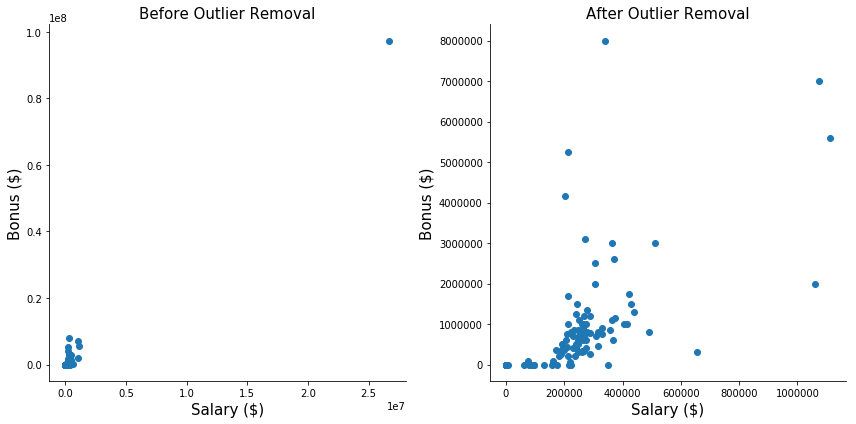

In [8]:
### Visualizing Salary v/s Balance Graphs for outlier identification
figure, (axes1, axes2) = plt.subplots(ncols=2, figsize=(12, 6))

axes1.scatter(enron_data.salary, enron_data.bonus)
axes1.set_xlabel("Salary ($)", fontsize=15)
axes1.set_ylabel("Bonus ($)", fontsize=15)
axes1.set_title("Before Outlier Removal", fontsize=15)
axes1.spines['right'].set_visible(False)
axes1.spines['top'].set_visible(False)

# Dropping the outliers
enron_data.drop(['TOTAL'], axis = 0, inplace=True)
enron_data.drop(['THE TRAVEL AGENCY IN THE PARK'], axis = 0, inplace= True)

axes2.scatter(enron_data.salary, enron_data.bonus)
axes2.set_xlabel("Salary ($)", fontsize=15)
axes2.set_ylabel("Bonus ($)", fontsize=15)
axes2.set_title("After Outlier Removal", fontsize=15)
axes2.spines['right'].set_visible(False)
axes2.spines['top'].set_visible(False)

figure.tight_layout()
plt.show()

## Feature Engineering

Feature engineering involves using human intuition to hypothesize what feature might contain pattern that can be exploited using machine learning, coding up the new feature, visualizing and repeating the same process again. Our hypothesis here - "POI's sent email to each other at a rate higher than for Non-POI's." I coded up two new features fraction of emails this person gets from poi (fraction_from_poi) and fraction of emails this person send to poi (fraction_to_poi). number of emails from this person to POI/total number of message from this person

$$ fraction\_from\_poi = \frac{number\ of\ emails\ from\ POI\ to\ this\ person}{total\ number\ of\ messages\ to\ this\  person} = \frac{from\_poi\_to\_this\_person}{to\_messages} $$

$$ fraction\_to\_poi = \frac{number\ of\ emails\ from\ this\ person\ to\ POI}{total\ number\ of\ messages\ from\ this\ person} = \frac{from\_this\_person\_to\_poi}{from\_messages} $$

When I visualize these new features, we can see that these new features provide discriminating power between POI and Non-POI. There is a good amount of feature space in the lower part of plot (on right) below 0.2 where there are no POIs.

In [9]:
### Creating new features fraction_from_poi and fraction_to_poi
enron_data["fraction_from_poi"] = enron_data["from_poi_to_this_person"].\
                                  divide(enron_data["to_messages"], fill_value=0.0) 

enron_data["fraction_to_poi"] = enron_data["from_this_person_to_poi"].\
                                divide(enron_data["from_messages"], fill_value=0.0)
enron_data['shared_receipt_poi_ratio'] = enron_data['shared_receipt_with_poi'].\
                                 divide(enron_data['to_messages'], fill_value=0.0)

enron_data['bonus_to_salary'] = enron_data['bonus'].divide(enron_data['salary'], fill_value=0.0)
enron_data['bonus_to_total'] = enron_data['bonus'].divide(enron_data['total_payments'], fill_value=0.0)

enron_data["fraction_from_poi"] = enron_data["fraction_from_poi"].fillna(0.0)
enron_data["fraction_to_poi"] = enron_data["fraction_to_poi"].fillna(0.0)
enron_data["shared_receipt_poi_ratio"] = enron_data["shared_receipt_poi_ratio"].fillna(0.0)
enron_data["bonus_to_salary"] = enron_data["bonus_to_salary"].fillna(0.0)
enron_data["bonus_to_total"] = enron_data["bonus_to_total"].fillna(0.0)

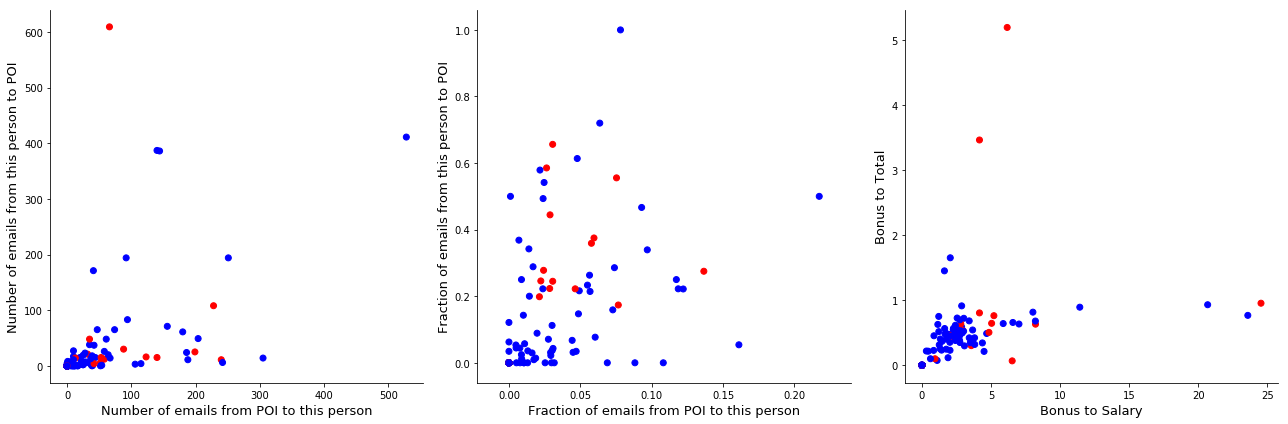

In [10]:
### Visualizing the effect of new features
figure, (axes1, axes2, axes3) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))

# Color scheme for plots
colors = np.where(enron_data["poi"] == 1, 'r', 'o')
colors[enron_data["poi"] == 0] = 'b'

axes1.scatter(enron_data["from_poi_to_this_person"], enron_data["from_this_person_to_poi"], color=colors)
axes1.set_xlabel("Number of emails from POI to this person", fontsize=13)
axes1.set_ylabel("Number of emails from this person to POI", fontsize=13)
axes1.spines['right'].set_visible(False)
axes1.spines['top'].set_visible(False)

axes2.scatter(enron_data["fraction_from_poi"], enron_data["fraction_to_poi"], color=colors)
axes2.set_xlabel("Fraction of emails from POI to this person", fontsize=13)
axes2.set_ylabel("Fraction of emails from this person to POI", fontsize=13)
axes2.spines['right'].set_visible(False)
axes2.spines['top'].set_visible(False)

axes3.scatter(enron_data["bonus_to_salary"], enron_data["bonus_to_total"], color=colors)
axes3.set_xlabel("Bonus to Salary", fontsize=13)
axes3.set_ylabel("Bonus to Total", fontsize=13)
axes3.spines['right'].set_visible(False)
axes3.spines['top'].set_visible(False)

figure.tight_layout()
plt.show()

## Feature Scaling

I have used **Decision Tree** and **Naive Bayes** as my final algorithm. Algorithms like decision tree and linear regression don't require feature scaling, whereas Support Vector Machines (SVM) and k-means clustering does.

**SVM** and **K-Means** clustering calculate Euclidean distance between points. If one of the features has a large range, the distance will be governed by this particular feature. These classifiers are affine transformation variant.

In case of **Linear Regression**, there is a coefficient with each feature. If a feature has large ranges that do not effect the label, regression algorithm will make the corresponding coefficients small. Even in case of tree based algorithms, we don't have to worry about one dimension, when we are doing something with the other. These classifers are **affine transformation invariant**.

## Feature Selection

Features $≠$ Information. We want to have the minimum number of features than capture trends and patterns in our data. We want to get rid of features that don't give us any information. Machine learning algorithm is just going to be as good as the features we put into it. It is critical that the methodology deployed for feature selection must be scientific and exhaustive without room for intuition.

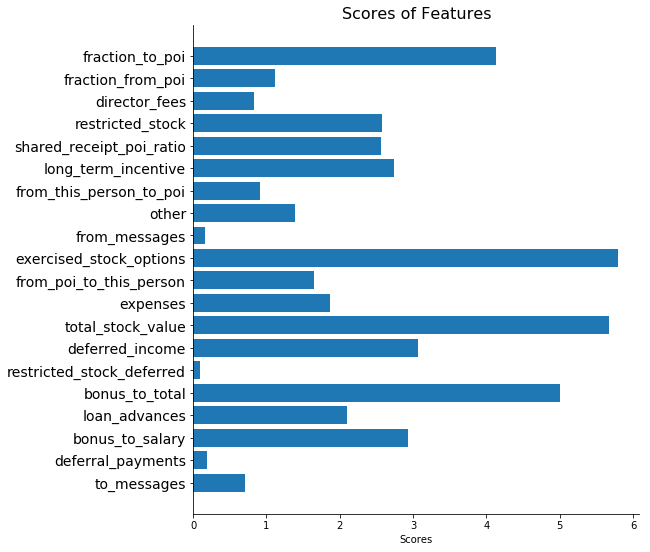

In [11]:
### Selecing the most important features for the given data

# Converting the boolean type of poi column to float values for classification
enron_data["poi"] = enron_data["poi"].astype(float)

features_list = ['to_messages', 'deferral_payments', 'bonus_to_salary',
                 'loan_advances', 'bonus_to_total', 'restricted_stock_deferred',
                 'deferred_income', 'total_stock_value', 'expenses',
                 'from_poi_to_this_person', 'exercised_stock_options', 'from_messages',
                 'other', 'from_this_person_to_poi', 'long_term_incentive',
                 'shared_receipt_poi_ratio', 'restricted_stock', 'director_fees',
                 'fraction_from_poi', 'fraction_to_poi']

labels = enron_data["poi"].tolist()
features = enron_data[features_list].values.tolist()

# Performing feature selection
selector = SelectKBest(f_classif, k=19)
selector.fit(features, labels)

scores = -np.log10(selector.pvalues_)

# Plotting the features wrt scores
figure, axes = plt.subplots(figsize=(8,9))
axes.barh(features_list, width=scores)
axes.set_yticklabels(features_list, fontsize=14)
axes.set_xlabel("Scores")
axes.set_title("Scores of Features", fontsize=16)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
plt.show()

In [12]:
### Updated Features

# Selecting all the features with score > 2
updated_features_list = ["bonus_to_total", "loan_advances", "bonus_to_salary", "deferred_income",
                         "total_stock_value", "exercised_stock_options", "long_term_incentive",
                         "shared_receipt_poi_ratio", "restricted_stock", "fraction_to_poi"]

labels = enron_data["poi"].tolist()
features = enron_data[features_list].values.tolist()

## Pick up an Algorithm

Different algorithms were attempted using the above mentioned feature list.
I tried **Decision Tree Classifier**, **Random Forest Classifier**, **Ada Boost Classifier**, **Gaussian Naive Bayes**, **K-Nearest Neighbors**

In [13]:
# Splitting up the data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=67)

In [14]:
### Trying differnet algorithms
algorithms = []
accuracy = []
precision = []
recall = []
f1score = []

models = [("Decision Tree Classifier", DecisionTreeClassifier(random_state=42)),
          ("Gaussian Naive Bayes", GaussianNB()),
          ("Random Forest Classifier", RandomForestClassifier(random_state=42, n_estimators=100)),
          ("K Nearest Neighbors", KNeighborsClassifier()),
          ("Ada Boost Classifier", AdaBoostClassifier(random_state=42)),
          ("Logistic Regression", LogisticRegression())]

for name, model in models:
    clf = model
    clf.fit(features_train, labels_train)
    predicitons = clf.predict(features_test)
    algorithms.append(name)
    accuracy.append(accuracy_score(labels_test, predicitons))
    precision.append(precision_score(labels_test, predicitons))
    recall.append(recall_score(labels_test, predicitons))
    f1score.append(f1_score(labels_test, predicitons))

evaluation_matrix = {"Algorithm": algorithms, "Accuracy": accuracy,
              "Precision": precision, "Recall": recall,
              "F1-Score": f1score}
evaluation = pd.DataFrame(evaluation_matrix)
evaluation

Algorithm  Accuracy  Precision  Recall  F1-Score
0  Decision Tree Classifier  0.886364   0.400000    0.50  0.444444
1      Gaussian Naive Bayes  0.840909   0.285714    0.50  0.363636
2  Random Forest Classifier  0.886364   0.333333    0.25  0.285714
3       K Nearest Neighbors  0.931818   0.666667    0.50  0.571429
4      Ada Boost Classifier  0.863636   0.333333    0.50  0.400000
5       Logistic Regression  0.840909   0.285714    0.50  0.363636

## Hyperparameters Optimization

Parameter tuning for an algorithm means selecting the good and robust parameter or set of parameters for an algorithm to optimize its performance. Default parameters may not be customized very well for the particular dataset features and might result in poor performance. Scikit learn provides two methods for algorithm parameter tuning/Hyperparameter optimization- GridSearchCV and RandomizedSearchCV.

I used **GridSearchCV** to do exhaustive search over different parameters and find the best parameters.

1. I used the **'f1'** as my *"scoring"* parameter to guide the parameter search process to minimize False positives and False negatives.
2. In the **"cv"** parameter, I passed a *cross validation* object **StratifiedShuffleSplit** to validate my search results that best adapt to my dataset characteristics.
3. I am choosing Decision Tree Classifier as my final algorithm, lets tune it below

In [15]:
### Tuning the Hyper-Parameters
clf_parameters = { 'criterion': ['gini', 'entropy'],
                   'max_depth': [None, 1, 2, 4, 5, 10, 15, 20],
                   'min_samples_split': [2, 4, 6, 8, 10, 20, 30, 40],
                   'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 30] }

cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=67)
clf = GridSearchCV(DecisionTreeClassifier(), param_grid = clf_parameters, cv = cv, scoring = 'f1')
clf.fit(features,labels)

best_clf_parameters = clf.best_estimator_
best_clf_parameters

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

*max_depth* determines when the splitting of decision tree node stops. *min_samples_split* monitors the amount of observations in an internal node; if a certain threshold is not reached (e.g min 5 people) no further splitting can be done. Very deep trees fit to quirks in data and perform well on training data, but will perform worse on test (unseen) data. We want our model to generalize better.

## Validate and Evaluate



**Validation** is the strategy to evaluate the performance of the model on unseen data. A classic mistake is to evaluate the performance of an algorithm on the same dataset it was trained on. It will make our algorithm perform better than it actually does. However, we will have no idea how our algorithm performs on unseen data.

It is essential practice in data mining procedures to keep a subset of data as holdout data- test data. We train our model on training data and examine the *generalization performance* of the model on the test data. We hide the label for target variable of the test data from the model and let the model predict the values for target variable. Then we compare the values predicted by the model with the hidden true values. We can also use a more sophisticated holdout training and testing procedure called cross-validation.

In our case, I used a variation of *k-fold cross-validation* called **StratifiedShuffleSplit**. StratifiedShuffleSplit will make randomly chosen training and test sets multiple times and average the results over all the tests. Data is first shuffled and then split into a pair of training and test sets. Stratification ensures training and test splits have class distribution (POI:Non-POI) that represents the overall data. Stratification is well suited in our case because of class imbalance (18 POI vs 128 Non-POI).

There are a number of evaluation metrics for classification challenges. In **balanced classes**, where all the labels are equally represented, we look at the classification **accuracy** of the model.

$$ Accuracy = \frac{Number\ of\ labels\ predicted\ correctly}{Total\ number\ of\ predicitions} = \frac{True\ Positives\ +\ True\ Negatives}{Total\ Predictions} $$

However, accuracy is not ideal for **skewed classes**. In our case, number of POI are small compared to non-POI (18 vs 128). We can have high accuracy by classifying many non-POI correctly and still not have a POI classiifed correctly. For imbalanced classes like we have, **Precision** and **Recall** are common measures of model performance.

$$ Precision = \frac{True\ Positive}{True\ Positive\ +\ False\ Positive} $$

$$ Recall = \frac{True\ Positive}{True\ Positive\ +\ False\ Positive} $$

A **good precision** means that whenever a POI gets flagged in my test set, I know with a lot of confidence that it's very likely to be a real POI and not a false alarm. A low precision indicates a large number of False Positives, where non-POI gets flagged as POI.

A **good recall** means nearly I am able to identify a POI everytime it shows up in test cases. A low recall indicates many False Negatives, where POIs don't get flagged correctly

F1 score conveys a balance between precision and recall. It is the harmonic mean of precision and recall.

$$ F_{1}\ Score = \frac{2 \cdot precision\cdot recall}{precision+ recall} $$

A **good F1-score** means both my false positives and false negatives are low, I can identify my POI's reliably and accurately. If my classifier flags a POI then the person is almost certainly a POI, and if the classifier does not flag someone, then they are almost certainly not a POI.

### Final Algorithm Performance

In [16]:
t0 = time()

clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

# clf = DecisionTreeClassifier(random_state=42)

clf.fit(features_train, labels_train)
predicitons = clf.predict(features_test)

accuracy.append((accuracy_score(labels_test, predicitons)))
precision.append((precision_score(labels_test, predicitons)))
recall.append((recall_score(labels_test, predicitons)))
f1score.append((f1_score(labels_test, predicitons)))

print("Accuracy:", round(accuracy_score(labels_test, predicitons), 3))
print("Precision:", round(precision_score(labels_test, predicitons), 3))
print("Recall:", round(recall_score(labels_test, predicitons), 3))
print("F1-Score:", round(f1_score(labels_test, predicitons), 3))
print("Done in", str(round(time()-t0, 3)) + "s")


Accuracy: 0.932
Precision: 0.667
Recall: 0.5
F1-Score: 0.571
Done in 0.006s


## Conclusion


The precision can be interpreted as the likelihood that a person who is identified as a POI is actually a true POI; the fact that this is 0.67 means that using this identifier to flag POI’s would result in 33% of the positive flags being false alarms. Recall measures how likely it is that identifier will flag a POI in the test set. 50% of the time it would catch that person, and 50% of the time it wouldn’t.
These numbers are quite good but we still can improve the strategy. One of the possible paths to improvement is digging in to the emails data more. The email features in the starter dataset were aggregated over all the messages for a given person. By digging into the text of each individual’s messages, it’s possible that more detailed patterns (say, messages to/from a specific address, rather than just messages to/from any POI address, or the usage of specific vocabulary terms) might emerge. Since we live in a world in which more POI finance data might not be easy to find, the next realistic thing to try might be to extract more data from the emails.

### References

1. [Enron Wiki](https://en.wikipedia.org/wiki/Enron)
2. [Scikit-learn](https://scikit-learn.org/stable/)
3. [Stackoverflow](https://stackoverflow.com/)


You can checkout the entire Git-Repository [here](https://github.com/bpagare6/Enron-Fraud-Detection) 